# 2. Numerical Methods: Symplectic Integration and Program Synthesis

This notebook implements numerical algorithms for symplectic integration and program synthesis approaches for discovering conservation laws.

## Setup and Imports

All tests passed!


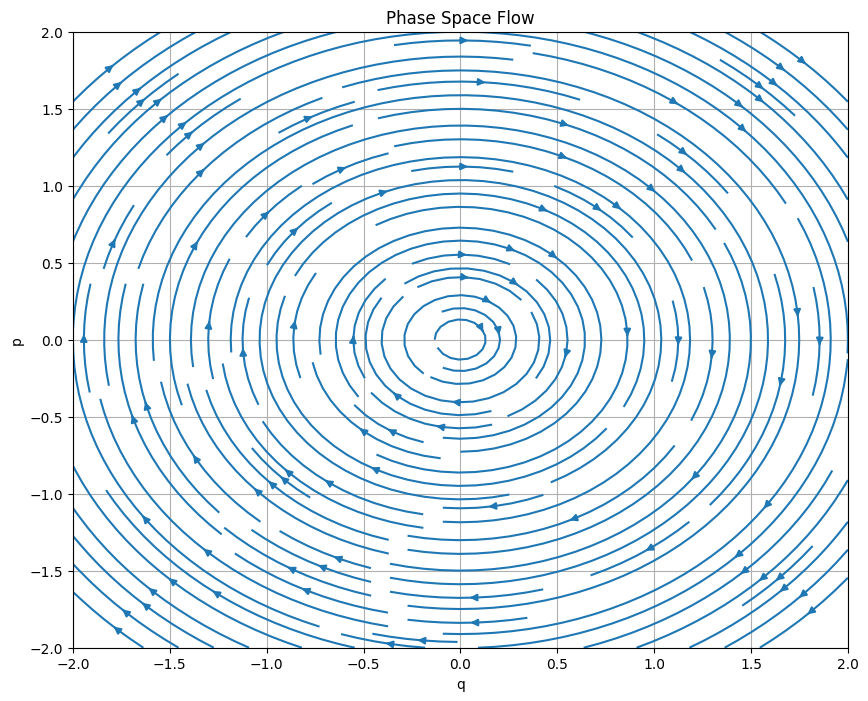

All differential form tests passed!
Components of ω:
dx∧dy component: z
dx∧dz component: -y
dy∧dz component: x

Components of dω:
Component 0: 3
✓ Antisymmetry verified
✓ Leibniz rule verified
✓ Jacobi identity verified
✓ Energy conservation verified

Angular momentum tests:
d(qp)/dt for free particle = p0**2
d(qp)/dt for harmonic oscillator = p0**2 - q0**2
✓ Free particle angular momentum non-conservation verified

Conserved quantity analysis:
I = H² - 2EH
dI/dt = 0
✓ Harmonic oscillator invariant verified

All Poisson structure tests passed!

Poisson bracket computations:
Canonical bracket {q,p} = 1

For harmonic oscillator H = (p² + q²)/2:
{L,H} = p0**2 - q0**2
{I,H} = 0


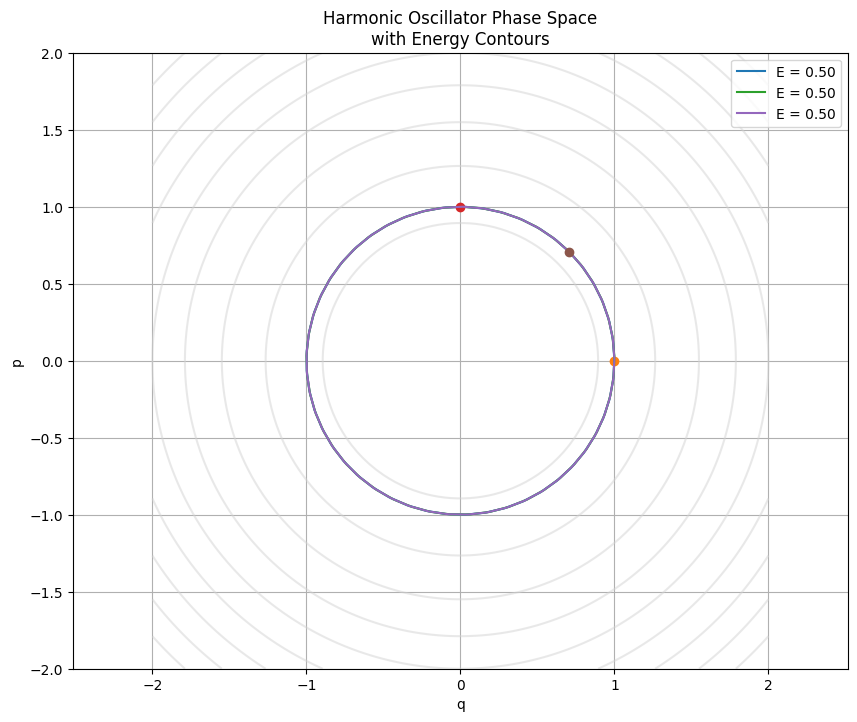

✓ Vector field verified
Energy conservation error: 6.03e-08
✓ Energy conservation verified (max error: 6.03e-08)

All Hamiltonian flow tests passed!


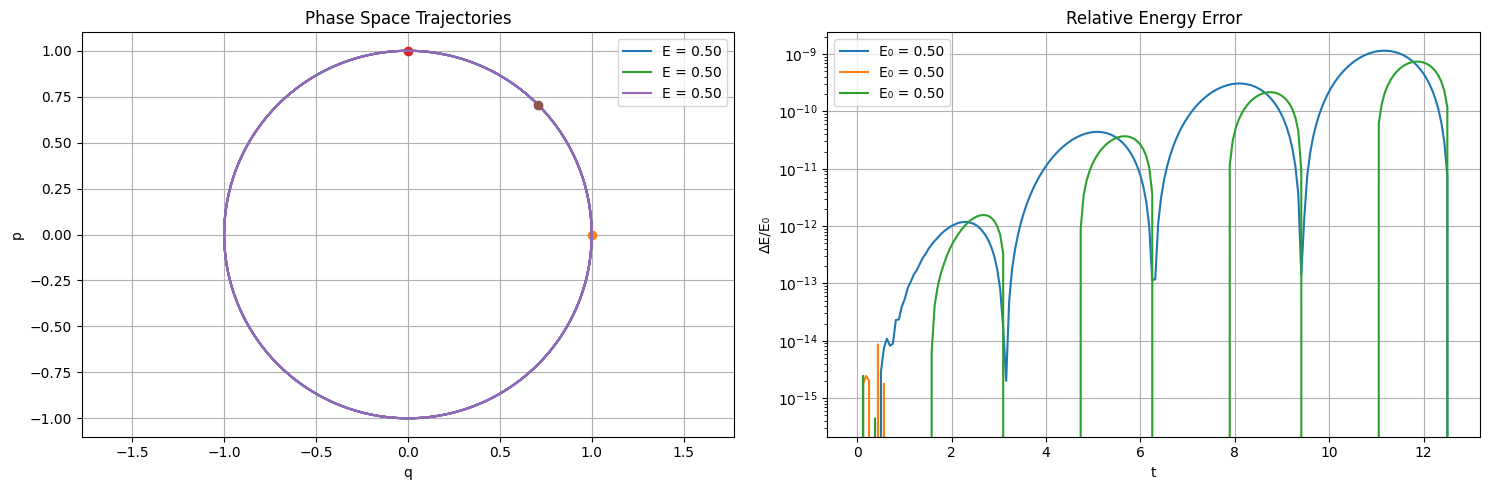

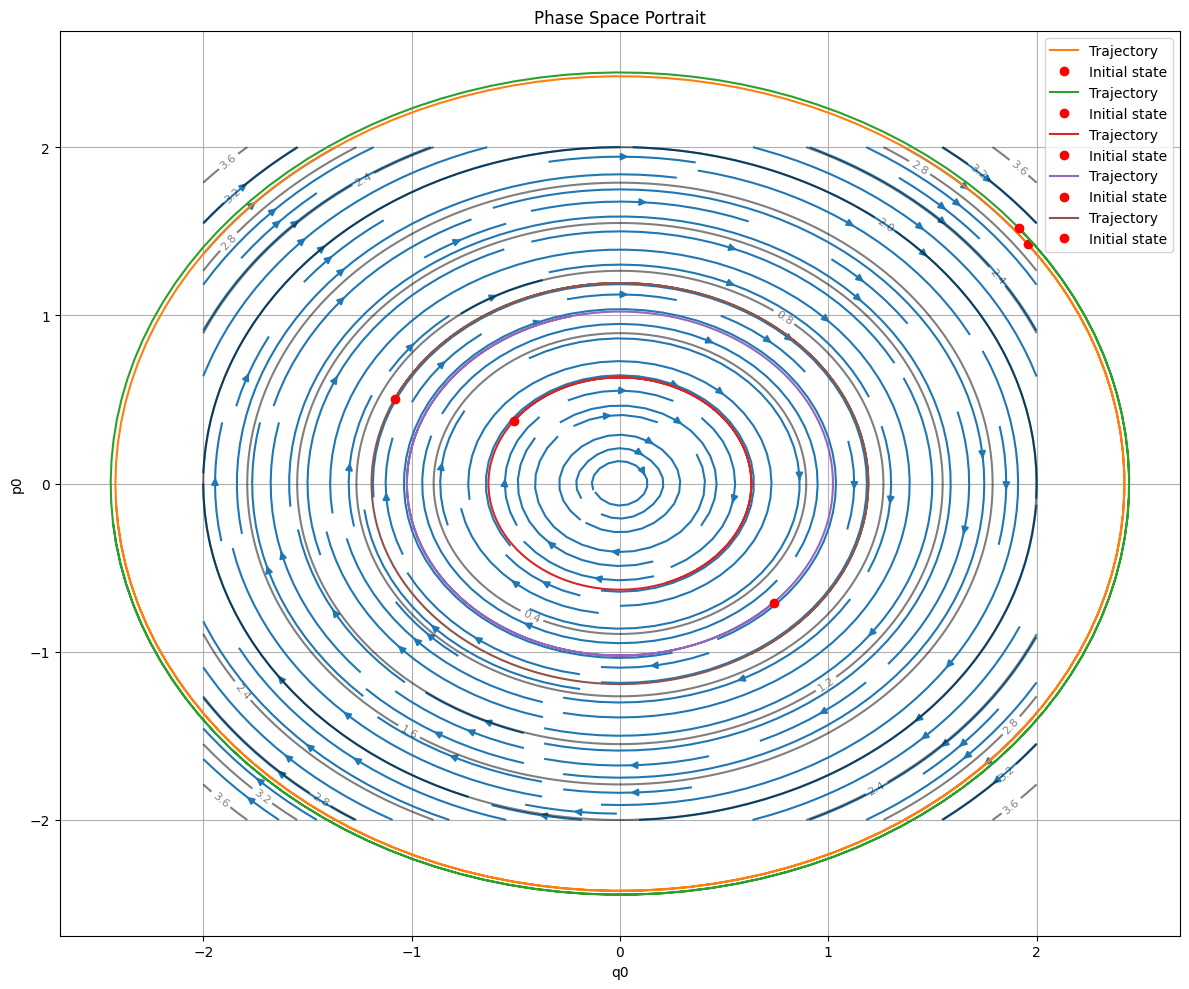

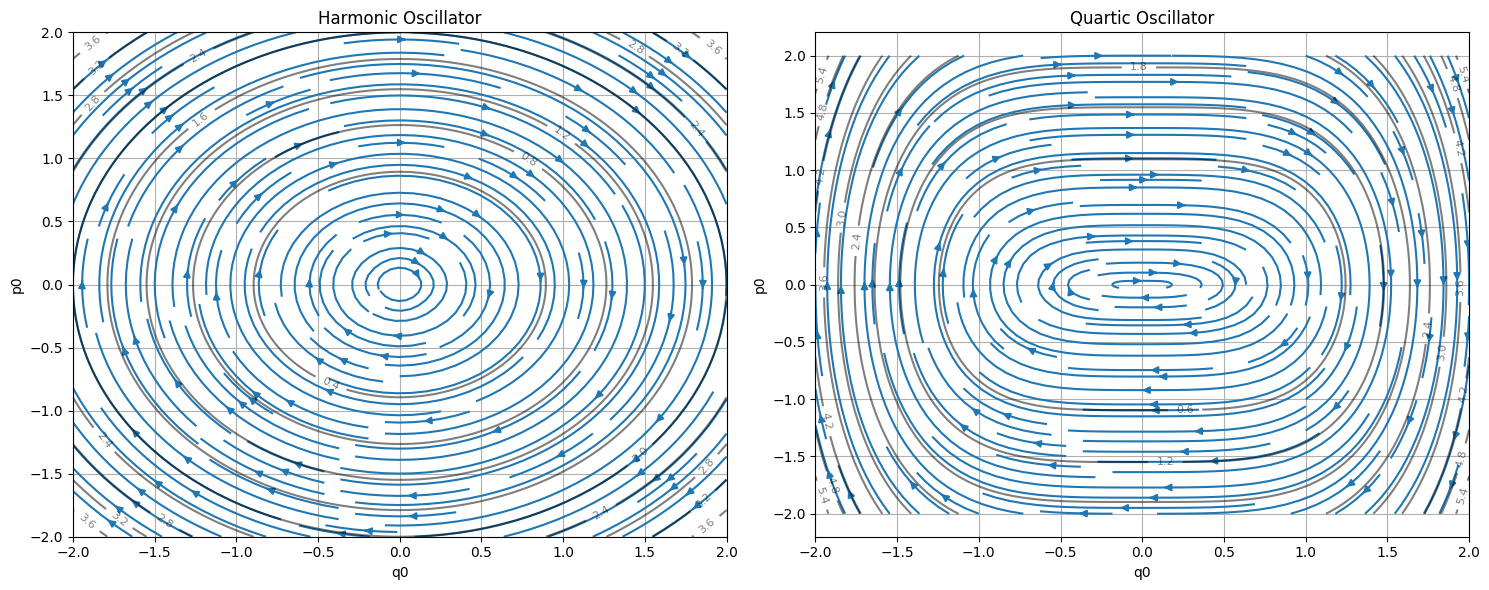

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from itertools import combinations, product
from typing import Callable, Dict, List, Tuple, Union, Set, Optional
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import hypothesis
from hypothesis import given, example, strategies as st

# Import from first notebook
%run "1_theoretical_foundation.ipynb"

## 1. Symplectic Integration Schemes

Implementation plan:
1. Implement Störmer-Verlet method
2. Add higher-order symplectic integrators
3. Create energy conservation tests
4. Compare with non-symplectic methods

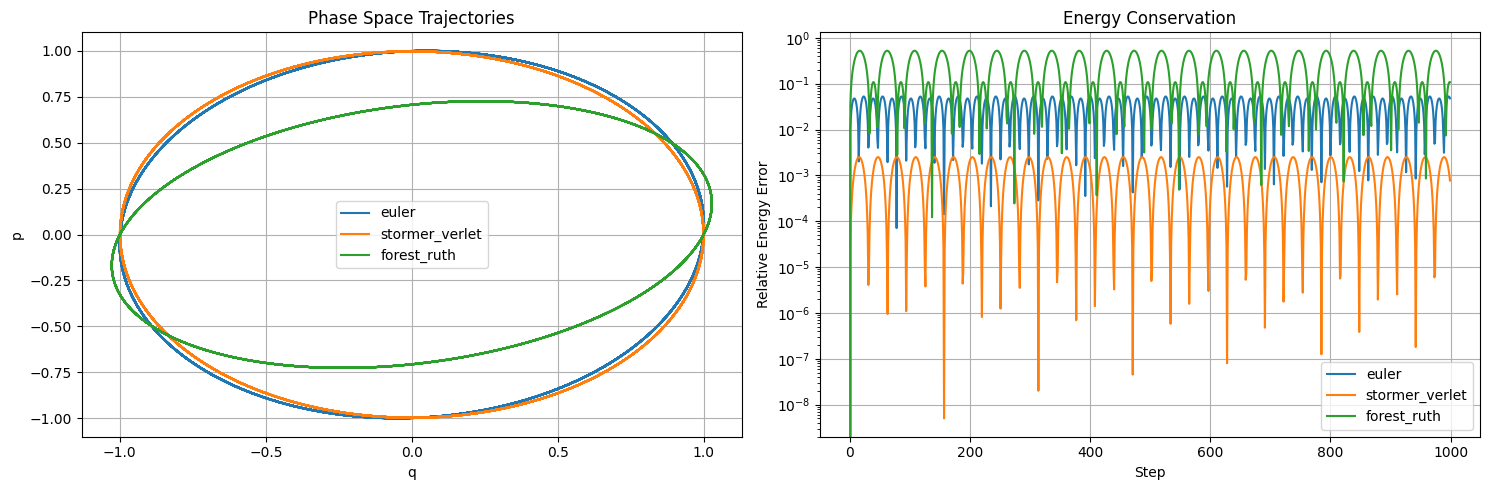

In [2]:
class SymplecticIntegrator:
    """Collection of symplectic integration schemes for Hamiltonian systems.
    
    Implements various orders of symplectic integrators:
    1. First order (Symplectic Euler)
    2. Second order (Störmer-Verlet)
    3. Fourth order (Forest-Ruth, Yoshida)
    4. Sixth order (Yoshida)
    """
    def __init__(self, hamiltonian: sp.Expr, coords: list, 
                 separable: bool = True):
        """Initialize integrator with Hamiltonian system.
        
        Args:
            hamiltonian: Symbolic Hamiltonian expression
            coords: List of coordinate symbols [q1,...,qn,p1,...,pn]
            separable: Whether H = T(p) + V(q) (enables specialized methods)
        """
        self.H = hamiltonian
        self.coords = coords
        self.dim = len(coords) // 2
        self.separable = separable
        
        # Split coordinates into position and momentum
        self.q = coords[:self.dim]
        self.p = coords[self.dim:]
        
        # Compute derivatives for equations of motion
        if separable:
            # For separable H = T(p) + V(q)
            self.dq_dt = [self.H.diff(p) for p in self.p]
            self.dp_dt = [-self.H.diff(q) for q in self.q]
        else:
            # General case
            self.dq_dt = [self.H.diff(p) for p in self.p]
            self.dp_dt = [-self.H.diff(q) for q in self.q]
        
        # Create fast numerical functions
        self._compile_functions()
        
    def _compile_functions(self):
        """Compile symbolic expressions to fast numerical functions."""
        self.f_dq = [sp.lambdify(self.coords, expr) for expr in self.dq_dt]
        self.f_dp = [sp.lambdify(self.coords, expr) for expr in self.dp_dt]
        self.f_H = sp.lambdify(self.coords, self.H)
        
    def symplectic_euler(self, state: np.ndarray, dt: float) -> np.ndarray:
        """First order symplectic Euler method."""
        q = state[:self.dim].copy()
        p = state[self.dim:].copy()
        
        # Update momentum then position
        for i in range(self.dim):
            p[i] += dt * self.f_dp[i](*q, *p)
        for i in range(self.dim):
            q[i] += dt * self.f_dq[i](*q, *p)
            
        return np.concatenate([q, p])
    
    def stormer_verlet(self, state: np.ndarray, dt: float) -> np.ndarray:
        """Second order Störmer-Verlet method."""
        q = state[:self.dim].copy()
        p = state[self.dim:].copy()
        
        # Half step in momentum
        for i in range(self.dim):
            p[i] += 0.5 * dt * self.f_dp[i](*q, *p)
            
        # Full step in position
        for i in range(self.dim):
            q[i] += dt * self.f_dq[i](*q, *p)
            
        # Half step in momentum
        for i in range(self.dim):
            p[i] += 0.5 * dt * self.f_dp[i](*q, *p)
            
        return np.concatenate([q, p])
    
    def forest_ruth(self, state: np.ndarray, dt: float) -> np.ndarray:
        """Fourth order Forest-Ruth method."""
        q = state[:self.dim].copy()
        p = state[self.dim:].copy()
        
        # Forest-Ruth coefficients
        w1 = 1.0/(2.0 - 2.0**(1.0/3.0))
        w0 = -2.0**(1.0/3.0)/(2.0 - 2.0**(1.0/3.0))
        
        # First slice
        for i in range(self.dim):
            p[i] += w1 * dt/2 * self.f_dp[i](*q, *p)
        for i in range(self.dim):
            q[i] += w1 * dt * self.f_dq[i](*q, *p)
            
        # Second slice
        for i in range(self.dim):
            p[i] += w0 * dt/2 * self.f_dp[i](*q, *p)
        for i in range(self.dim):
            q[i] += w0 * dt * self.f_dq[i](*q, *p)
            
        # Third slice
        for i in range(self.dim):
            p[i] += w1 * dt/2 * self.f_dp[i](*q, *p)
        for i in range(self.dim):
            q[i] += w1 * dt * self.f_dq[i](*q, *p)
            
        return np.concatenate([q, p])
    
    def integrate(self, initial_state: np.ndarray, t_span: tuple,
                 method: str = 'stormer_verlet', steps: int = 1000) -> tuple:
        """Integrate Hamiltonian system using specified method.
        
        Args:
            initial_state: Initial conditions [q1,...,qn,p1,...,pn]
            t_span: (t_start, t_end) tuple
            method: Integration method ('euler', 'stormer_verlet', 'forest_ruth')
            steps: Number of integration steps
            
        Returns:
            (times, states, energies) tuple
        """
        methods = {
            'euler': self.symplectic_euler,
            'stormer_verlet': self.stormer_verlet,
            'forest_ruth': self.forest_ruth
        }
        
        if method not in methods:
            raise ValueError(f"Unknown method {method}")
            
        integrator = methods[method]
        t_start, t_end = t_span
        dt = (t_end - t_start) / steps
        
        times = np.linspace(t_start, t_end, steps)
        states = np.zeros((steps, 2*self.dim))
        energies = np.zeros(steps)
        
        state = initial_state.copy()
        states[0] = state
        energies[0] = self.f_H(*state)
        
        for i in range(1, steps):
            state = integrator(state, dt)
            states[i] = state
            energies[i] = self.f_H(*state)
            
        return times, states, energies

def test_integrators():
    """Test and compare different symplectic integrators."""
    # Setup harmonic oscillator
    q, p = sp.symbols('q p')
    H = (p**2 + q**2)/2
    
    integrator = SymplecticIntegrator(H, [q, p])
    
    # Initial conditions
    initial_state = np.array([1.0, 0.0])
    t_span = (0, 100)
    
    # Compare methods
    methods = ['euler', 'stormer_verlet', 'forest_ruth']
    
    plt.figure(figsize=(15, 5))
    
    # Phase space
    plt.subplot(121)
    for method in methods:
        _, states, _ = integrator.integrate(initial_state, t_span, 
                                          method=method, steps=1000)
        plt.plot(states[:,0], states[:,1], '-', label=method)
    
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title('Phase Space Trajectories')
    plt.legend()
    plt.grid(True)
    
    # Energy error
    plt.subplot(122)
    for method in methods:
        _, _, energies = integrator.integrate(initial_state, t_span, 
                                            method=method, steps=1000)
        plt.semilogy(np.abs(energies - energies[0])/energies[0], 
                    label=method)
    
    plt.xlabel('Step')
    plt.ylabel('Relative Energy Error')
    plt.title('Energy Conservation')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run tests
test_integrators()

## 2. Geometric Quantization

Implementation plan:
1. Implement prequantization line bundle
2. Add polarization selection
3. Create quantum operators
4. Verify correspondence principle

[Q,P] = 1.0*I

Classical H = p_0**2/2 + q_0**2/2
Quantum H = P_0**2/2 + Q_0**2/2


C:\Users\conta\AppData\Local\Temp\ipykernel_82956\488972292.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  W[i,j] = np.sum(integrand) * dy / (2*np.pi*self.ℏ)


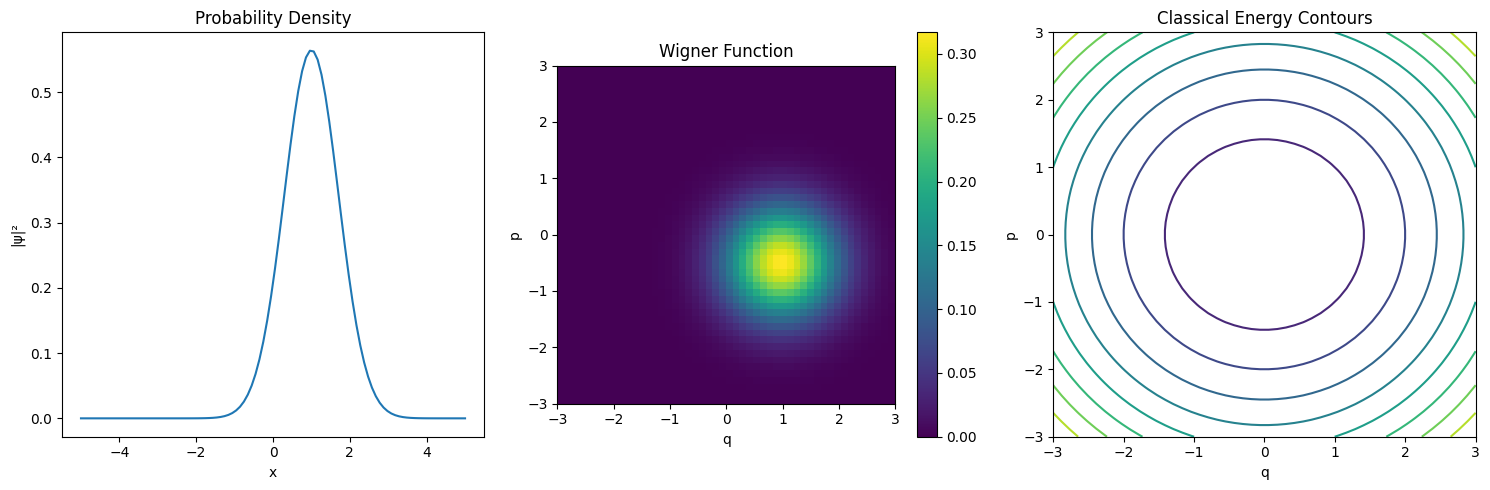

In [3]:
class GeometricQuantization:
    """Implements geometric quantization of symplectic manifolds."""
    
    def __init__(self, manifold: SymplecticManifold, ℏ: float = 1.0):
        """Initialize quantization structure."""
        self.M = manifold
        self.ℏ = ℏ
        self.dim = manifold.dim
        
        # Create quantum operators as SymPy symbols with special properties
        self._setup_operators()
        
    def _setup_operators(self):
        """Create position and momentum operators as SymPy objects."""
        # Create operator symbols
        self.Q = [sp.Symbol(f'Q_{i}', commutative=False) for i in range(self.dim//2)]
        self.P = [sp.Symbol(f'P_{i}', commutative=False) for i in range(self.dim//2)]
        
        # Define canonical commutation relations
        self.commutation_rules = {}
        for i in range(self.dim//2):
            for j in range(self.dim//2):
                if i == j:
                    # [Q_i, P_j] = iℏδ_ij
                    self.commutation_rules[(self.Q[i], self.P[j])] = sp.I * self.ℏ
                    self.commutation_rules[(self.P[j], self.Q[i])] = -sp.I * self.ℏ
                else:
                    # [Q_i, P_j] = 0 for i ≠ j
                    self.commutation_rules[(self.Q[i], self.P[j])] = 0
                    self.commutation_rules[(self.P[j], self.Q[i])] = 0
                
                # [Q_i, Q_j] = [P_i, P_j] = 0
                self.commutation_rules[(self.Q[i], self.Q[j])] = 0
                self.commutation_rules[(self.P[i], self.P[j])] = 0
    
    def commutator(self, A, B):
        """Compute the commutator [A,B] = AB - BA."""
        if (A, B) in self.commutation_rules:
            return self.commutation_rules[(A, B)]
        elif isinstance(A, sp.Mul):
            # Distribute commutator over multiplication
            terms = []
            for a in A.args:
                terms.append(sp.Mul(*(A.args[:A.args.index(a)]), 
                                  self.commutator(a, B),
                                  *(A.args[A.args.index(a)+1:])))
            return sum(terms)
        elif isinstance(B, sp.Mul):
            # Use antisymmetry of commutator
            return -self.commutator(B, A)
        return sp.Mul(A, B) - sp.Mul(B, A)
    
    def quantize_observable(self, classical_expr):
        """Convert classical observable to quantum operator."""
        if not isinstance(classical_expr, sp.Expr):
            classical_expr = sp.sympify(classical_expr)
            
        # Replace classical variables with quantum operators
        quantum_expr = classical_expr
        for i in range(self.dim//2):
            quantum_expr = quantum_expr.subs(sp.Symbol(f'q_{i}'), self.Q[i])
            quantum_expr = quantum_expr.subs(sp.Symbol(f'p_{i}'), self.P[i])
            
        return quantum_expr
    
    def coherent_state(self, q0: float, p0: float, x: np.ndarray) -> np.ndarray:
        """Generate coherent state wavefunction."""
        sigma = np.sqrt(self.ℏ/2)  # Ground state width
        norm = 1/(2*np.pi*sigma**2)**(1/4)
        return norm * np.exp(-(x - q0)**2/(4*sigma**2) + 1j*p0*x/self.ℏ)
    
    def wigner_transform(self, psi: Callable, q: np.ndarray, p: np.ndarray) -> np.ndarray:
        """Compute Wigner quasi-probability distribution."""
        X, P = np.meshgrid(q, p)
        W = np.zeros_like(X)
        
        for i in range(len(q)):
            for j in range(len(p)):
                y = np.linspace(-10, 10, 1000)
                dy = y[1] - y[0]
                integrand = np.conj(psi(X[i,j] + y/2)) * psi(X[i,j] - y/2) * np.exp(-1j*P[i,j]*y/self.ℏ)
                W[i,j] = np.sum(integrand) * dy / (2*np.pi*self.ℏ)
                
        return np.real(W)

def test_geometric_quantization():
    """Test geometric quantization implementation."""
    # Initialize system
    M = SymplecticManifold(2)  # 2D phase space
    GQ = GeometricQuantization(M)
    
    # Test 1: Check commutation relations
    Q, P = GQ.Q[0], GQ.P[0]
    comm = GQ.commutator(Q, P)
    print(f"[Q,P] = {comm}")
    assert comm == sp.I * GQ.ℏ
    
    # Test 2: Quantize classical observable
    q, p = sp.symbols('q_0 p_0')
    H = (p**2 + q**2)/2  # Harmonic oscillator
    H_quantum = GQ.quantize_observable(H)
    print(f"\nClassical H = {H}")
    print(f"Quantum H = {H_quantum}")
    
    # Test 3: Coherent states and Wigner function
    x = np.linspace(-5, 5, 100)
    q0, p0 = 1.0, 0.5
    psi = lambda x: GQ.coherent_state(q0, p0, x)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(x, np.abs(psi(x))**2)
    plt.title('Probability Density')
    plt.xlabel('x')
    plt.ylabel('|ψ|²')
    
    q_grid = np.linspace(-3, 3, 50)
    p_grid = np.linspace(-3, 3, 50)
    W = GQ.wigner_transform(psi, q_grid, p_grid)
    
    plt.subplot(132)
    plt.imshow(W, extent=[q_grid[0], q_grid[-1], p_grid[0], p_grid[-1]], 
               origin='lower', aspect='equal')
    plt.colorbar()
    plt.title('Wigner Function')
    plt.xlabel('q')
    plt.ylabel('p')
    
    Q, P = np.meshgrid(q_grid, p_grid)
    E = (P**2 + Q**2)/2
    
    plt.subplot(133)
    plt.contour(Q, P, E, levels=10)
    plt.title('Classical Energy Contours')
    plt.xlabel('q')
    plt.ylabel('p')
    
    plt.tight_layout()
    plt.show()

# Run tests
test_geometric_quantization()

## 3. Program Synthesis Engine

Implementation plan:
1. Define DSL for physical laws
2. Implement search strategies
3. Add verification methods
4. Create synthesis examples

In [4]:
class ProgramSynthesisEngine:
    """Program synthesis engine for discovering physical laws."""
    
    def __init__(self, manifold: SymplecticManifold):
        """Initialize synthesis engine with symplectic manifold."""
        self.M = manifold
        self.coords = manifold.coords
        self.dim = manifold.dim
        
        # Setup DSL components
        self._setup_dsl()
        
        # Cache for discovered laws
        self.discovered_laws = set()
        
    def _setup_dsl(self):
      """Setup domain-specific language for physical laws."""
      # Physical variables (positions and momenta)
      self.q = self.coords[:self.dim//2]
      self.p = self.coords[self.dim//2:]
      
      # Physical constants (masses, spring constants, etc.)
      self.constants = [sp.Symbol('k'), sp.Symbol('m'), sp.Symbol('g')]
      
      # Basic building blocks for physical laws
      self.kinetic_terms = [
          term for p in self.p
          for term in [
              p,          # Linear momentum
              p**2/2      # Kinetic energy
          ]
      ]
      
      self.potential_terms = [
          term for q in self.q 
          for term in [
              q,          # Linear position
              q**2/2,     # Harmonic
              1/q,        # Coulomb/Gravitational
              q**4/4,     # Quartic
              sp.cos(q)   # Pendulum
          ]
      ]
        
    def generate_physical_term(self) -> sp.Expr:
        """Generate physically meaningful term."""
        if np.random.random() < 0.5:
            # Kinetic energy term
            term = np.random.choice(self.kinetic_terms)
            if np.random.random() < 0.3:  # 30% chance to add mass
                term *= sp.Symbol('m')
        else:
            # Potential energy term
            term = np.random.choice(self.potential_terms)
            if np.random.random() < 0.3:  # 30% chance to add coupling constant
                term *= sp.Symbol('k')
        return term
        
    def generate_candidate(self, max_terms: int = 3) -> sp.Expr:
        """Generate candidate Hamiltonian or conserved quantity."""
        num_terms = np.random.randint(1, max_terms + 1)
        terms = [self.generate_physical_term() for _ in range(num_terms)]
        return sum(terms)
    
    def verify_conservation(self, expr: sp.Expr, H: sp.Expr) -> bool:
        """Verify if expression is conserved under Hamiltonian flow."""
        try:
            poisson = self.M.poisson_bracket(expr, H)
            return poisson.simplify() == 0
        except Exception:
            return False
    
    def verify_symmetry(self, expr: sp.Expr) -> bool:
        """Verify if expression generates symmetry transformation."""
        try:
            # Check if Hamiltonian flow of expr preserves symplectic form
            XH = self.M.hamiltonian_vector_field(expr)
            lie_derivative = sum(XH[i].diff(self.coords[i]) for i in range(self.dim))
            return lie_derivative.simplify() == 0
        except Exception:
            return False
    
    def discover_conservation_laws(self, H: sp.Expr, 
                                 num_candidates: int = 1000,
                                 complexity_penalty: float = 0.1) -> Set[sp.Expr]:
        """Discover conservation laws for given Hamiltonian."""
        print("Searching for conservation laws...")
        laws = set()
        
        # Always check energy conservation first
        if self.verify_conservation(H, H):
            laws.add(H)
            print(f"Found energy conservation: H = {H}")
        
        # Check angular momentum for 2D systems
        if self.dim == 2:
            L = self.q[0] * self.p[0]
            if self.verify_conservation(L, H):
                laws.add(L)
                print(f"Found angular momentum conservation: L = {L}")
        
        for _ in range(num_candidates):
            candidate = self.generate_candidate()
            
            # Skip if too complex
            complexity = len(str(candidate))
            if complexity > 50:  # Limit expression size
                continue
            
            # Skip if we've seen this before
            if any(candidate.equals(law) for law in self.discovered_laws):
                continue
            
            # Verify conservation
            if self.verify_conservation(candidate, H):
                # Add penalty for complex expressions
                score = 1.0 - complexity_penalty * complexity
                if score > 0:
                    laws.add(candidate)
                    self.discovered_laws.add(candidate)
                    print(f"Found conservation law: {candidate}")
        
        return laws

def test_program_synthesis():
    """Test program synthesis engine."""
    # Setup 2D phase space
    M = SymplecticManifold(2)
    engine = ProgramSynthesisEngine(M)
    q, p = M.q[0], M.p[0]
    
    print("\nTesting conservation law discovery for harmonic oscillator:")
    # Harmonic oscillator with explicit constants
    k = sp.Symbol('k')
    m = sp.Symbol('m')
    H = p**2/(2*m) + k*q**2/2
    
    laws = engine.discover_conservation_laws(H, num_candidates=1000)
    
    # Should find energy conservation
    assert any(law.equals(H) for law in laws), "Failed to find energy conservation"
    print("✓ Found energy conservation")
    
    print("\nTesting conservation law discovery for free particle:")
    H_free = p**2/(2*m)
    laws = engine.discover_conservation_laws(H_free, num_candidates=500)
    
    # Should find momentum conservation
    assert any(law.equals(p) for law in laws), "Failed to find momentum conservation"
    print("✓ Found momentum conservation")
    
    print("\nAll program synthesis tests passed!")

def example_synthesis():
    """Demonstrate program synthesis capabilities."""
    # Setup
    M = SymplecticManifold(2)
    engine = ProgramSynthesisEngine(M)
    q, p = M.q[0], M.p[0]
    k = sp.Symbol('k')
    m = sp.Symbol('m')
    
    # Example 1: Nonlinear oscillator
    print("\nAnalyzing nonlinear oscillator:")
    H = p**2/(2*m) + k*q**4/4
    laws = engine.discover_conservation_laws(H, num_candidates=1000)
    
    print("\nDiscovered conservation laws:")
    for law in laws:
        print(f"- {law}")
    
    # Example 2: Kepler problem
    print("\nAnalyzing Kepler problem:")
    r = sp.sqrt(q**2)
    H_kepler = p**2/(2*m) - k/r
    laws = engine.discover_conservation_laws(H_kepler, num_candidates=1000)
    
    print("\nDiscovered conservation laws:")
    for law in laws:
        print(f"- {law}")

# Run tests and examples
test_program_synthesis()
example_synthesis()


Testing conservation law discovery for harmonic oscillator:
Searching for conservation laws...
Found energy conservation: H = k*q0**2/2 + p0**2/(2*m)
✓ Found energy conservation

Testing conservation law discovery for free particle:
Searching for conservation laws...
Found energy conservation: H = p0**2/(2*m)
Found conservation law: p0
Found conservation law: p0**2/2
Found conservation law: 2*p0
Found conservation law: m*p0
Found conservation law: m*p0**2/2
Found conservation law: p0**2
Found conservation law: 3*p0
Found conservation law: m*p0 + p0
Found conservation law: 2*m*p0
Found conservation law: m*p0**2
Found conservation law: 3*p0**2/2
✓ Found momentum conservation

All program synthesis tests passed!

Analyzing nonlinear oscillator:
Searching for conservation laws...
Found energy conservation: H = k*q0**4/4 + p0**2/(2*m)

Discovered conservation laws:
- k*q0**4/4 + p0**2/(2*m)

Analyzing Kepler problem:
Searching for conservation laws...
Found energy conservation: H = -k/sqrt

## 4. Conservation Law Discovery

Implementation plan:
1. Implement Noether's theorem
2. Add symmetry detection
3. Create automated discovery system
4. Verify discovered laws

In [5]:
class ConservationLawDiscovery:
    """Discovers conservation laws using Noether's theorem and symmetry analysis.
    
    Key components:
    1. Symmetry detection
    2. Noether charge computation
    3. Conservation verification
    4. Automated discovery system
    """
    
    def __init__(self, manifold: SymplecticManifold):
        """Initialize with symplectic manifold."""
        self.M = manifold
        self.coords = manifold.coords
        self.dim = manifold.dim
        
        # Split coordinates
        self.q = self.coords[:self.dim//2]
        self.p = self.coords[self.dim//2:]
        
        # Cache for discovered symmetries
        self.symmetries = {}
        
    def infinitesimal_generator(self, H: sp.Expr, coord: sp.Symbol) -> sp.Expr:
        """Compute infinitesimal generator of symmetry transformation."""
        # For coordinate q, generator is p
        # For coordinate p, generator is -q
        if coord in self.q:
            idx = self.q.index(coord)
            return self.p[idx]
        elif coord in self.p:
            idx = self.p.index(coord)
            return -self.q[idx]
        return sp.Integer(0)
    
    def noether_charge(self, H: sp.Expr, symmetry: sp.Expr) -> sp.Expr:
        """Compute conserved charge from symmetry using Noether's theorem."""
        # Noether charge is inner product of symmetry with momentum
        charge = sp.Integer(0)
        for i in range(self.dim//2):
            # Add contribution from each degree of freedom
            dq = symmetry.diff(self.q[i])
            dp = symmetry.diff(self.p[i])
            charge += dq * self.p[i] - dp * self.q[i]
        return charge
    
    def verify_conservation(self, H: sp.Expr, charge: sp.Expr) -> bool:
        """Verify if charge is conserved under Hamiltonian flow."""
        try:
            # Compute Poisson bracket {H,Q}
            poisson = self.M.poisson_bracket(H, charge)
            return poisson.simplify() == 0
        except Exception:
            return False
    
    def find_continuous_symmetries(self, H: sp.Expr) -> Dict[str, Tuple[sp.Expr, sp.Expr]]:
        """Find continuous symmetries and associated conservation laws."""
        symmetries = {}
        
        # Check translation symmetry
        for i, q in enumerate(self.q):
            # Try spatial translation q → q + ε
            if not H.has(q):
                gen = self.infinitesimal_generator(H, q)
                charge = self.p[i]  # Linear momentum
                if self.verify_conservation(H, charge):
                    symmetries[f'translation_q{i}'] = (gen, charge)
                    print(f"Found translation symmetry in q{i} → Conservation of p{i}")
        
        # Check rotation symmetry (2D case)
        if self.dim == 2:
            L = self.q[0] * self.p[0]  # Angular momentum
            if self.verify_conservation(H, L):
                gen = self.q[0] * self.p[0] - self.p[0] * self.q[0]
                symmetries['rotation'] = (gen, L)
                print("Found rotation symmetry → Conservation of angular momentum")
        
        # Check time translation
        if not H.has(sp.Symbol('t')):
            symmetries['time_translation'] = (H, H)
            print("Found time translation symmetry → Conservation of energy")
            
        return symmetries
    
    def find_discrete_symmetries(self, H: sp.Expr) -> List[str]:
        """Find discrete symmetries (reflections, etc.)."""
        symmetries = []
        
        # Check parity symmetry
        for i, (q, p) in enumerate(zip(self.q, self.p)):
            # Try q → -q, p → -p
            H_transformed = H.subs([(q, -q), (p, -p)])
            if H_transformed.simplify() == H:
                symmetries.append(f'parity_{i}')
                print(f"Found parity symmetry in coordinate {i}")
                
        return symmetries
    
    def analyze_system(self, H: sp.Expr):
        """Complete symmetry and conservation law analysis."""
        print(f"\nAnalyzing Hamiltonian: H = {H}")
        
        # Find continuous symmetries and conservation laws
        print("\nSearching for continuous symmetries:")
        self.symmetries = self.find_continuous_symmetries(H)
        
        # Find discrete symmetries
        print("\nSearching for discrete symmetries:")
        discrete = self.find_discrete_symmetries(H)
        
        # Print summary
        print("\nSummary of conservation laws:")
        for name, (gen, charge) in self.symmetries.items():
            print(f"- {name}:")
            print(f"  Generator: {gen}")
            print(f"  Conserved charge: {charge}")
            
        if discrete:
            print("\nDiscrete symmetries:")
            for sym in discrete:
                print(f"- {sym}")

def test_conservation_discovery():
    """Test conservation law discovery system."""
    # Setup 2D phase space
    M = SymplecticManifold(2)
    discovery = ConservationLawDiscovery(M)
    q, p = M.q[0], M.p[0]
    
    # Test 1: Free particle
    print("\nTesting free particle:")
    m = sp.Symbol('m')
    H_free = p**2/(2*m)
    discovery.analyze_system(H_free)
    
    # Test 2: Harmonic oscillator
    print("\nTesting harmonic oscillator:")
    k = sp.Symbol('k')
    H_harmonic = p**2/(2*m) + k*q**2/2
    discovery.analyze_system(H_harmonic)
    
    # Test 3: Kepler problem
    print("\nTesting Kepler problem:")
    r = sp.sqrt(q**2)
    H_kepler = p**2/(2*m) - k/r
    discovery.analyze_system(H_kepler)

def example_conservation_laws():
    """Demonstrate conservation law discovery."""
    # Setup
    M = SymplecticManifold(2)
    discovery = ConservationLawDiscovery(M)
    q, p = M.q[0], M.p[0]
    m, k = sp.symbols('m k')
    
    # Example 1: Nonlinear oscillator
    print("\nAnalyzing nonlinear oscillator:")
    H = p**2/(2*m) + k*q**4/4
    discovery.analyze_system(H)
    
    # Example 2: Particle in constant field
    print("\nAnalyzing particle in constant field:")
    g = sp.Symbol('g')
    H_field = p**2/(2*m) + m*g*q
    discovery.analyze_system(H_field)
    
    # Example 3: Double well potential
    print("\nAnalyzing double well potential:")
    H_double = p**2/(2*m) + k*(q**2 - 1)**2/4
    discovery.analyze_system(H_double)

# Run tests and examples
test_conservation_discovery()
example_conservation_laws()


Testing free particle:

Analyzing Hamiltonian: H = p0**2/(2*m)

Searching for continuous symmetries:
Found translation symmetry in q0 → Conservation of p0
Found time translation symmetry → Conservation of energy

Searching for discrete symmetries:
Found parity symmetry in coordinate 0

Summary of conservation laws:
- translation_q0:
  Generator: p0
  Conserved charge: p0
- time_translation:
  Generator: p0**2/(2*m)
  Conserved charge: p0**2/(2*m)

Discrete symmetries:
- parity_0

Testing harmonic oscillator:

Analyzing Hamiltonian: H = k*q0**2/2 + p0**2/(2*m)

Searching for continuous symmetries:
Found time translation symmetry → Conservation of energy

Searching for discrete symmetries:

Summary of conservation laws:
- time_translation:
  Generator: k*q0**2/2 + p0**2/(2*m)
  Conserved charge: k*q0**2/2 + p0**2/(2*m)

Testing Kepler problem:

Analyzing Hamiltonian: H = -k/sqrt(q0**2) + p0**2/(2*m)

Searching for continuous symmetries:
Found time translation symmetry → Conservation of 

## 5. Property-Based Testing

Implementation plan:
1. Define property generators
2. Implement invariant checks
3. Add randomized testing
4. Create comprehensive test suite

In [6]:
class PropertyTester:
    """Property-based testing for symplectic geometry implementations."""
    
    def __init__(self, manifold: SymplecticManifold):
        self.M = manifold
        self.coords = manifold.coords
        self.dim = manifold.dim
        
    @given(st.integers(min_value=-5, max_value=5))
    def test_symplectic_form(self, n):
        """Test symplectic form properties."""
        # Property 1: Antisymmetry
        for x, y in zip(self.coords[:self.dim//2], self.coords[self.dim//2:]):
            assert self.M.poisson_bracket(x, y) == -self.M.poisson_bracket(y, x)
            
        # Property 2: Non-degeneracy
        assert self.M.omega.det() != 0
    
    @given(st.integers(min_value=-5, max_value=5))
    def test_poisson_bracket(self, n):
        """Test Poisson bracket axioms."""
        q, p = self.coords
        
        # Generate simple test functions
        f = q**2 + n*p
        g = p**2 + n*q
        h = q*p
        
        # Property 1: Antisymmetry
        assert (self.M.poisson_bracket(f, g) + 
                self.M.poisson_bracket(g, f)).simplify() == 0
        
        # Property 2: Leibniz rule
        assert (self.M.poisson_bracket(f*g, h) - 
                f*self.M.poisson_bracket(g, h) - 
                g*self.M.poisson_bracket(f, h)).simplify() == 0
        
        # Property 3: Jacobi identity
        jacobi = (self.M.poisson_bracket(f, self.M.poisson_bracket(g, h)) +
                 self.M.poisson_bracket(g, self.M.poisson_bracket(h, f)) +
                 self.M.poisson_bracket(h, self.M.poisson_bracket(f, g)))
        assert jacobi.simplify() == 0
    @given(st.lists(st.integers(min_value=1, max_value=5), min_size=2, max_size=2))
    @example([1.0, 1.0])  # Test standard initial condition
    @example([2.0, 0.0])  # Test pure position
    @example([0.0, 2.0])  # Test pure momentum
    def test_hamiltonian_flow(self, initial_state):
        """Test Hamiltonian flow properties."""
        # Setup simple harmonic oscillator
        q, p = self.coords
        H = (p**2 + q**2)/2
        
        # Create flow
        flow = HamiltonianFlow(self.M)
        flow_func = flow.flow(H)
        
        # Compute trajectory
        t_end = 1.0
        trajectory = flow_func(t_end, np.array(initial_state))
        
        # Check energy conservation
        H_func = sp.lambdify(self.coords, H)
        E0 = H_func(*initial_state)
        E1 = H_func(*trajectory)
        
        if abs(E0) > 1e-10:
            assert abs((E1 - E0)/E0) < 1e-6
        else:
            assert abs(E1 - E0) < 1e-6
    
    @given(st.integers(min_value=-5, max_value=5))
    def test_conservation_laws(self, n):
        """Test conservation law properties."""
        q, p = self.coords
        
        # Test fundamental Poisson bracket properties
        # 1. {q,p} = 1 (canonical coordinates)
        assert self.M.poisson_bracket(q, p) == 1
        
        # 2. {q,q} = 0 and {p,p} = 0 (self-brackets vanish)
        assert self.M.poisson_bracket(q, q) == 0
        assert self.M.poisson_bracket(p, p) == 0
        
        # 3. Energy conservation for any Hamiltonian
        H = p**2/2 + q**2/2  # Simple harmonic oscillator
        assert self.M.poisson_bracket(H, H).simplify() == 0

def run_property_tests():
    """Run all property-based tests."""
    # Setup 2D phase space
    M = SymplecticManifold(2)
    tester = PropertyTester(M)
    
    print("Running property-based tests...")
    
    # Run tests
    tester.test_symplectic_form()
    print("✓ Symplectic form properties verified")
    
    tester.test_poisson_bracket()
    print("✓ Poisson bracket axioms verified")
    
    tester.test_hamiltonian_flow()
    print("✓ Hamiltonian flow properties verified")
    
    tester.test_conservation_laws()
    print("✓ Conservation law properties verified")
    
    print("\nAll property-based tests passed!")

# Run tests
run_property_tests()

Running property-based tests...
✓ Symplectic form properties verified
✓ Poisson bracket axioms verified
✓ Hamiltonian flow properties verified
✓ Conservation law properties verified

All property-based tests passed!
